# BGS Signal-to-Noise Ratio and Redshift Efficiency

The goal of this notebook is to assess the signal-to-noise ratio and redshift efficiency of BGS targets observed in "nominal" observing conditions (which are defined [here](https://github.com/desihub/desisurvey/blob/master/py/desisurvey/data/config.yaml#L102) and discussed [here](https://github.com/desihub/desisurvey/issues/77), among other places).  Specifically, the nominal BGS observing conditions we adopt (note the 5-minute exposure time is with the moon down!) are:

```python
{'AIRMASS': 1.0,
 'EXPTIME': 300,
 'SEEING': 1.1,
 'MOONALT': -60,
 'MOONFRAC': 0.0,
 'MOONSEP': 180}
```

During the survey itself, observations with the moon up (i.e., during bright time) will be obtained with longer exposure times according to the bright-time exposure-time model (see [here](https://github.com/desihub/surveysim/tree/master/doc/nb)).

Because we fix the observing conditions, we only consider how redshift efficiency depends on galaxy properties (apparent magnitude, redshift, 4000-A break, etc.).  However, note that the code is structured such that we *could* (now or in the future) explore variations in seeing, exposure time, and lunar parameters.

### Preliminaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import seaborn as sns

In [2]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2 

In [3]:
from desispec.io.util import write_bintable
from desiutil.log import get_logger
log = get_logger()

In [4]:
%matplotlib inline

In [5]:
sns.set(style='ticks', font_scale=1.4, palette='Set2')
col = sns.color_palette()

### Establish the I/O path, output filename, and random seed. 

In [6]:
simdir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'sim', 'bgs')

In [7]:
simseed = 555
simrand = np.random.RandomState(simseed)

### All or none of the output files can be overwritten using these keywords.

In [8]:
overwrite_spectra = False
overwrite_redshifts = False
overwrite_results = False

### Read a handful of healpixels from the BGS/MXXL mock.

This mock provides the correct redshift distribution and correlation between redshift and apparent magnitude for the BGS sample.  In particular, we will use the magnitude distribution to reweight the redshift efficiencies we derive.

Note that we set the velocity dispersion of every mock galaxy to a fiducial value of 100 km/s.

In [9]:
def read_bgs_mock():
    import desitarget.mock.io as mockio
    mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 
                            'desi_footprint', 'v0.0.4', 'BGS_r20.6.hdf5')
    mockdata = mockio.read_durham_mxxl_hdf5(mockfile, rand=simrand, nside=32, nproc=nproc,
                                        healpixels=[3151,3150,3149,3148])
    print(mockdata.keys())
    mockdata['VDISP'] = np.repeat(100.0, len(mockdata['RA'])) # [km/s]
    return mockdata

In [10]:
mockdata = read_bgs_mock()

INFO:io.py:859:read_durham_mxxl_hdf5: Assigning healpix pixels with nside = 32
INFO:io.py:869:read_durham_mxxl_hdf5: Trimmed to 38857 BGSs in healpixels [3151, 3150, 3149, 3148]
dict_keys(['SEED', 'BRICKNAME', 'OBJID', 'VDISP', 'N_PER_FILE', 'DEC', 'MOCKID', 'RA', 'MAG', 'Z', 'TEMPLATETYPE', 'FILTERNAME', 'TRUESPECTYPE', 'TEMPLATESUBTYPE', 'SDSS_01gr', 'FILES', 'SDSS_absmag_r01'])


In [11]:
def qa_radec():
    fig, ax = plt.subplots()
    ax.scatter(mockdata['RA'], mockdata['DEC'], s=1)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

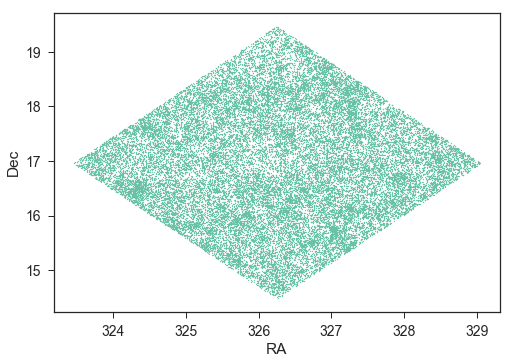

In [12]:
qa_radec()

In [13]:
def qa_zmag(redshift, mag, maglabel='r (AB mag)', faintmag=20.0):
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    _ = ax[0].hist(redshift, bins=100)
    ax[0].set_xlabel('Redshift')
    ax[0].set_ylabel('Number of Galaxies')
 
    _ = ax[1].hist(mag, bins=100)
    ax[1].axvline(x=faintmag, ls='--', color='k')
    ax[1].set_xlabel(maglabel)
    ax[1].set_ylabel('Number of Galaxies')

    ax[2].scatter(redshift, mag, s=3, alpha=0.75)
    ax[2].axhline(y=faintmag, ls='--', color='k')
    ax[2].set_xlabel('Redshift')
    ax[2].set_ylabel(maglabel)
    
    plt.subplots_adjust(wspace=0.3)

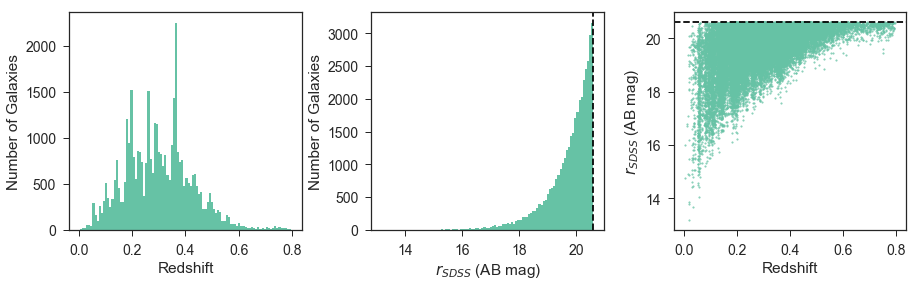

In [14]:
qa_zmag(mockdata['Z'], mockdata['MAG'], maglabel=r'$r_{SDSS}$ (AB mag)', faintmag=20.6)

### Use a KD tree to assign a basis template to each mock galaxy.

To assign a (continuum) template we use the algorithm developed for the Data Challenge, which uses a simple KD tree constructed from the rest-frame color, magnitude, and redshift of each mock galaxy. See desitarget.mock.spectra for more details.

[Note that we don't use this for the baseline redshift efficiencies but I'm keeping it here because the code may be useful in other contexts.]

In [15]:
class BGStree(object):
    """Build a KD Tree."""
    def __init__(self):
        from speclite import filters
        from scipy.spatial import cKDTree as KDTree
        from desisim.io import read_basis_templates

        self.bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)
        self.bgs_tree = KDTree(self._bgs())

    def _bgs(self):
        """Quantities we care about: redshift (z), M_0.1r, and 0.1(g-r).

        """
        zobj = self.bgs_meta['Z'].data
        mabs = self.bgs_meta['SDSS_UGRIZ_ABSMAG_Z01'].data
        rmabs = mabs[:, 2]
        gr = mabs[:, 1] - mabs[:, 2]

        return np.vstack((zobj, rmabs, gr)).T        
    
    def query(self, objtype, matrix, subtype=''):
        """Return the nearest template number based on the KD Tree.

        Args:
          objtype (str): object type
          matrix (numpy.ndarray): (M,N) array (M=number of properties,
            N=number of objects) in the same format as the corresponding
            function for each object type (e.g., self.bgs).
          subtype (str, optional): subtype (only for white dwarfs)

        Returns:
          dist: distance to nearest template
          indx: index of nearest template
        
        """
        if objtype.upper() == 'BGS':
            dist, indx = self.bgs_tree.query(matrix)
        else:
            log.warning('Unrecognized SUBTYPE {}!'.format(subtype))
            raise ValueError
                
        return dist, indx    

In [16]:
class BGStemplates(object):
    """Generate spectra.  

    """
    def __init__(self, wavemin=None, wavemax=None, dw=0.2, 
                 rand=None, verbose=False):

        from desimodel.io import load_throughput

        self.tree = BGStree()

        # Build a default (buffered) wavelength vector.
        if wavemin is None:
            wavemin = load_throughput('b').wavemin - 10.0
        if wavemax is None:
            wavemax = load_throughput('z').wavemax + 10.0
            
        self.wavemin = wavemin
        self.wavemax = wavemax
        self.dw = dw
        self.wave = np.arange(round(wavemin, 1), wavemax, dw)

        self.rand = rand
        self.verbose = verbose

        # Initialize the templates once:
        from desisim.templates import BGS
        self.bgs_templates = BGS(wave=self.wave, normfilter='sdss2010-r') # Need to generalize this!
        self.bgs_templates.normline = None # no emission lines!

    def bgs(self, data, index=None, mockformat='durham_mxxl_hdf5'):
        """Generate spectra for BGS.

        Currently only the MXXL (durham_mxxl_hdf5) mock is supported.  DATA
        needs to have Z, SDSS_absmag_r01, SDSS_01gr, VDISP, and SEED, which are
        assigned in mock.io.read_durham_mxxl_hdf5.  See also BGSKDTree.bgs().

        """
        from desisim.io import empty_metatable

        objtype = 'BGS'
        if index is None:
            index = np.arange(len(data['Z']))
            
        input_meta = empty_metatable(nmodel=len(index), objtype=objtype)
        for inkey, datakey in zip(('SEED', 'MAG', 'REDSHIFT', 'VDISP'),
                                  ('SEED', 'MAG', 'Z', 'VDISP')):
            input_meta[inkey] = data[datakey][index]

        if mockformat.lower() == 'durham_mxxl_hdf5':
            alldata = np.vstack((data['Z'][index],
                                 data['SDSS_absmag_r01'][index],
                                 data['SDSS_01gr'][index])).T
            _, templateid = self.tree.query(objtype, alldata)
        else:
            raise ValueError('Unrecognized mockformat {}!'.format(mockformat))

        input_meta['TEMPLATEID'] = templateid
        flux, _, meta = self.bgs_templates.make_templates(input_meta=input_meta,
                                                          nocolorcuts=True, novdisp=False,
                                                          verbose=self.verbose)

        return flux, meta        

## Set up the simulation parameters.

Here we use the mock to capture the correct distribution of apparent magnitudes, galaxy properties, and redshifts.

In [17]:
# Vary galaxy properties with nominal observing conditions but split 
# the sample into nsim chunks to avoid memory issues.
sim1 = dict(suffix='sim01',
            use_mock=True,
            nsim=10,
            nspec=100,
            seed=11,
           )

Note that if `use_mock=False` then *rmagmin*, *rmagmax*, *zmin*, and *zmax* are required. For example, here's another possible simulation of 1000 spectra in which the magnitude (r=19.5) and redshift (z=0.2) are held fixed while moonfrac and moonsep are varied (as well as intrinsic galaxy properties):

```python
sim2 = dict(suffix='sim02',
            use_mock=False,
            nsim=10,
            nspec=100,
            seed=22,
            zmin=0.2, zmax=0.2,
            rmagmin=19.5, rmagmax=19.5,
            moonfracmin=0.0, moonfracmax=1.0,
            moonsepmin=0.0, moonsepmax=120.0,
           )
```

In [18]:
#from desisim.simexp import reference_conditions
#ref_obsconditions = reference_conditions['BGS']
ref_obsconditions = {'AIRMASS': 1.0, 'EXPTIME': 300, 'SEEING': 1.1, 'MOONALT': -60, 'MOONFRAC': 0.0, 'MOONSEP': 180}
print(ref_obsconditions)

{'SEEING': 1.1, 'MOONSEP': 180, 'MOONALT': -60, 'AIRMASS': 1.0, 'EXPTIME': 300, 'MOONFRAC': 0.0}


In [19]:
def bgs_write_simdata(sim, rand, overwrite=False):
    """Build and write a metadata table with the simulation inputs.  
    Currently, the only quantities that can be varied are moonfrac, 
    moonsep, and exptime, but more choices can be added as needed.
    
    """
    from desispec.io.util import makepath
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
    makepath(simdatafile)
        
    cols = [
        ('SEED', 'S20'),
        ('NSPEC', 'i4'),
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('SEEING', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4')]
    simdata = Table(np.zeros(sim['nsim'], dtype=cols))
    
    simdata['EXPTIME'].unit = 's'
    simdata['SEEING'].unit = 'arcsec'
    simdata['MOONSEP'].unit = 'deg'
    simdata['MOONALT'].unit = 'deg'

    simdata['SEED'] = sim['seed']
    simdata['NSPEC'] = sim['nspec']
    simdata['AIRMASS'] = ref_obsconditions['AIRMASS']
    simdata['SEEING'] = ref_obsconditions['SEEING']
    simdata['MOONALT'] = ref_obsconditions['MOONALT']
    
    if 'moonfracmin' in sim.keys():
        simdata['MOONFRAC'] = rand.uniform(sim['moonfracmin'], sim['moonfracmax'], sim['nsim'])
    else:
        simdata['MOONFRAC'] = ref_obsconditions['MOONFRAC']

    if 'moonsepmin' in sim.keys():
        simdata['MOONSEP'] = rand.uniform(sim['moonsepmin'], sim['moonsepmax'], sim['nsim'])
    else:
        simdata['MOONSEP'] = ref_obsconditions['MOONSEP']
        
    if 'exptime' in sim.keys():
        simdata['EXPTIME'] = rand.uniform(sim['exptimemin'], sim['exptimemax'], sim['nsim'])
    else:
        simdata['EXPTIME'] = ref_obsconditions['EXPTIME']
        
    if overwrite or not os.path.isfile(simdatafile):     
        print('Writing {}'.format(simdatafile))
        write_bintable(simdatafile, simdata, extname='SIMDATA', clobber=True)
        
    return simdata

In [20]:
def simdata2obsconditions(simdata):
    obs = dict(AIRMASS=simdata['AIRMASS'], 
               EXPTIME=simdata['EXPTIME'],
               MOONALT=simdata['MOONALT'],
               MOONFRAC=simdata['MOONFRAC'],
               MOONSEP=simdata['MOONSEP'],
               SEEING=simdata['SEEING'])
    return obs

In [21]:
def write_templates(outfile, flux, wave, meta):
    import astropy.units as u
    from astropy.io import fits

    hx = fits.HDUList()
    hdu_wave = fits.PrimaryHDU(wave)
    hdu_wave.header['EXTNAME'] = 'WAVE'
    hdu_wave.header['BUNIT'] = 'Angstrom'
    hdu_wave.header['AIRORVAC']  = ('vac', 'Vacuum wavelengths')
    hx.append(hdu_wave)    
    
    fluxunits = 1e-17 * u.erg / (u.s * u.cm**2 * u.Angstrom)
    hdu_flux = fits.ImageHDU(flux)
    hdu_flux.header['EXTNAME'] = 'FLUX'
    hdu_flux.header['BUNIT'] = str(fluxunits)
    hx.append(hdu_flux)
    
    hdu_meta = fits.table_to_hdu(meta)
    hdu_meta.header['EXTNAME'] = 'METADATA'
    hx.append(hdu_meta)

    print('Writing {}'.format(outfile))
    hx.writeto(outfile, clobber=True)

In [22]:
def bgs_make_templates(sim, rand, BGSmaker):
    """Generate the actual templates.  If using the mock data then iterate 
    until we build the desired number of models after applying targeting cuts, 
    otherwise use specified priors on magnitude and redshift.
    
    """
    from desitarget.cuts import isBGS_bright, isBGS_faint
    from astropy.table import vstack
    
    if sim['use_mock']:
        natatime = np.min( (50, sim['nspec']) )
        ngood = 0
        flux, meta = [], []
        while ngood < sim['nspec']:
            these = rand.choice(len(mockdata['RA']), natatime)
            flux1, meta1 = BGSmaker.bgs(mockdata, index=these)
            
            keep = np.logical_or( isBGS_bright(rflux=meta1['FLUX_R'].data), 
                                 isBGS_faint(rflux=meta1['FLUX_R'].data) )
            ngood1 = np.count_nonzero(keep)
            if ngood1 > 0:
                ngood += ngood1
                flux.append(flux1[keep, :])
                meta.append(meta1[keep])
            
        meta = vstack(meta)[:sim['nspec']]
        flux = np.vstack(flux)[:sim['nspec'], :]
        wave = BGSmaker.wave
        
    else:
        redshift = rand.uniform(sim['zmin'], sim['zmax'], size=sim['nspec'])
        rmag = rand.uniform(sim['rmagmin'], sim['rmagmax'], size=sim['nspec'])

        flux, wave, meta = BGSmaker.bgs_templates.make_templates(
            nmodel=sim['nspec'], redshift=redshift, mag=rmag, seed=sim['seed'])

    return flux, wave, meta

In [23]:
def bgs_sim_spectra(sim, overwrite=False, verbose=False):
    """Generate spectra for a given set of simulation parameters with 
    the option of overwriting files.
    
    """
    from desisim.scripts.quickspectra import sim_spectra
    
    rand = np.random.RandomState(sim['seed'])
    BGSmaker = BGStemplates(rand=rand, verbose=verbose)
    
    # Generate the observing conditions table.
    simdata = bgs_write_simdata(sim, rand, overwrite=overwrite)

    for ii, simdata1 in enumerate(simdata):

        # Generate the observing conditions dictionary.  
        obs = simdata2obsconditions(simdata1)
        
        # Generate the rest-frame templates.  Currently not writing out the rest-frame 
        # templates but we could.
        flux, wave, meta = bgs_make_templates(sim, rand, BGSmaker)
        
        truefile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-true.fits'.format(sim['suffix'], ii))
        if overwrite or not os.path.isfile(truefile):    
            write_templates(truefile, flux, wave, meta)
    
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
        if overwrite or not os.path.isfile(spectrafile):
            sim_spectra(wave, flux, 'bgs', spectrafile, obsconditions=obs, 
                        sourcetype='bgs', seed=sim['seed'], expid=ii)
        else:
            print('File {} exists...skipping.'.format(spectrafile))

## Generate the spectra.

In [24]:
for sim in np.atleast_1d(sim1):
    bgs_sim_spectra(sim, verbose=False, overwrite=overwrite_spectra)

INFO:io.py:955:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:967:read_basis_templates: Reading /Users/ioannis/work/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-001.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-002.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-003.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-004.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-005.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-006.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-007.fits exists...skipping.
File

## Fit the redshifts.

This step took ~1.8 seconds per spectrum, ~3 minutes per 100 spectra, or ~30 minutes for all 1000 spectra with my 4-core laptop.

In [25]:
def bgs_redshifts(sim, overwrite=False):
    """Fit for the redshifts.
    
    """
    from redrock.external.desi import rrdesi    
    
    for ii in range(sim['nsim']):
        zbestfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-zbest.fits'.format(sim['suffix'], ii))
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
    
        if overwrite or not os.path.isfile(zbestfile):
            rrdesi(options=['--zbest', zbestfile, '--ncpu', str(nproc), spectrafile])
        else:
            print('File {} exists...skipping.'.format(zbestfile))    

In [26]:
for sim in np.atleast_1d(sim1):
    bgs_redshifts(sim, overwrite=overwrite_redshifts)

File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-000-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-001-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-002-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-003-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-004-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-005-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-006-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-007-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-008-zbest.fits exists...skipping.
File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-009-zbest.fits exists...skipping.


## Gather the results.

In [27]:
def bgs_gather_results(sim, overwrite=False):
    """Gather all the pieces so we can make plots.
    
    """
    from desispec.io.spectra import read_spectra
    from desispec.io.zfind import read_zbest
    
    nspec = sim['nspec']
    nall = nspec * sim['nsim']
    
    resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
    if not os.path.isfile(resultfile) or overwrite:
        pass
    else:
        log.info('File {} exists...skipping.'.format(resultfile))
        return
    
    cols = [
        ('EXPTIME', 'f4'),
        ('AIRMASS', 'f4'),
        ('MOONFRAC', 'f4'),
        ('MOONSEP', 'f4'),
        ('MOONALT', 'f4'),
        ('SNR_B', 'f4'),
        ('SNR_R', 'f4'),
        ('SNR_Z', 'f4'),
        ('TARGETID', 'i8'),
        ('TEMPLATEID', 'i4'),
        ('RMAG', 'f4'),
        ('GR', 'f4'),
        ('D4000', 'f4'),
        ('EWHBETA', 'f4'), 
        ('ZTRUE', 'f4'), 
        ('Z', 'f4'), 
        ('ZERR', 'f4'), 
        ('ZWARN', 'f4')]
    result = Table(np.zeros(nall, dtype=cols))

    result['EXPTIME'].unit = 's'
    result['MOONSEP'].unit = 'deg'
    result['MOONALT'].unit = 'deg'
    
    # Read the simulation parameters data table.
    simdatafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-simdata.fits'.format(sim['suffix']))
    simdata = Table.read(simdatafile)

    for ii, simdata1 in enumerate(simdata):
        # Copy over some data.
        result['EXPTIME'][nspec*ii:nspec*(ii+1)] = simdata1['EXPTIME']
        result['AIRMASS'][nspec*ii:nspec*(ii+1)] = simdata1['AIRMASS']
        result['MOONFRAC'][nspec*ii:nspec*(ii+1)] = simdata1['MOONFRAC']
        result['MOONSEP'][nspec*ii:nspec*(ii+1)] = simdata1['MOONSEP']
        result['MOONALT'][nspec*ii:nspec*(ii+1)] = simdata1['MOONALT']
        
        # Read the metadata table.
        truefile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-true.fits'.format(sim['suffix'], ii))
        if os.path.isfile(truefile):
            log.info('Reading {}'.format(truefile))        
            meta = Table.read(truefile)

            #result['TARGETID'][nspec*ib:nspec*(ii+1)] = truth['TARGETID']
            result['TEMPLATEID'][nspec*ii:nspec*(ii+1)] = meta['TEMPLATEID']
            result['RMAG'][nspec*ii:nspec*(ii+1)] = 22.5 - 2.5 * np.log10(meta['FLUX_R'])
            result['GR'][nspec*ii:nspec*(ii+1)] = -2.5 * np.log10(meta['FLUX_G'] / meta['FLUX_R'])
            result['D4000'][nspec*ii:nspec*(ii+1)] = meta['D4000']
            result['EWHBETA'][nspec*ii:nspec*(ii+1)] = meta['EWHBETA']
            result['ZTRUE'][nspec*ii:nspec*(ii+1)] = meta['REDSHIFT']

        # Read the zbest file. 
        zbestfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}-zbest.fits'.format(sim['suffix'], ii))
        if os.path.isfile(zbestfile):
            log.info('Reading {}'.format(zbestfile))
            zbest = read_zbest(zbestfile)
            # Assume the tables are row-ordered!
            result['Z'][nspec*ii:nspec*(ii+1)] = zbest.z
            result['ZERR'][nspec*ii:nspec*(ii+1)] = zbest.zerr
            result['ZWARN'][nspec*ii:nspec*(ii+1)] = zbest.zwarn
            
        # Finally, read the spectra to get the S/N.
        spectrafile = os.path.join(simdir, sim['suffix'], 'bgs-{}-{:03}.fits'.format(sim['suffix'], ii))
        if os.path.isfile(spectrafile):  
            log.info('Reading {}'.format(spectrafile))
            spec = read_spectra(spectrafile)
            for band in ('b','r','z'):
                for iobj in range(nspec):
                    these = np.where((spec.wave[band] > np.mean(spec.wave[band])-50) * 
                                     (spec.wave[band] < np.mean(spec.wave[band])+50) * 
                                     (spec.flux[band][iobj, :] > 0))[0]
                    result['SNR_{}'.format(band.upper())][nspec*ii+iobj] = (
                        np.median( spec.flux[band][iobj, these] * np.sqrt(spec.ivar[band][iobj, these]) ) 
                    )
                    
    log.info('Writing {}'.format(resultfile))
    write_bintable(resultfile, result, extname='RESULTS', clobber=True)

In [28]:
for sim in np.atleast_1d(sim1):
    bgs_gather_results(sim, overwrite=overwrite_results)

INFO:<ipython-input-27-ffb7b08a398d>:15:bgs_gather_results: File /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-results.fits exists...skipping.


## Analyze the outputs.

We only have one simulation so the code below is hard-coded to sim1, although it would be trivial to generalize.

In [29]:
sim = sim1
resultfile = os.path.join(simdir, sim['suffix'], 'bgs-{}-results.fits'.format(sim['suffix']))
log.info('Reading {}'.format(resultfile))
result = Table.read(resultfile)
result

INFO:<ipython-input-29-e234fe7cbb3a>:3:<module>: Reading /Users/ioannis/work/desi/spectro/sim/bgs/sim01/bgs-sim01-results.fits


EXPTIME,AIRMASS,MOONFRAC,MOONSEP,MOONALT,SNR_B,SNR_R,SNR_Z,TARGETID,TEMPLATEID,RMAG,GR,D4000,EWHBETA,ZTRUE,Z,ZERR,ZWARN
s,,,deg,deg,,,,,,,,,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,float32,float32,float32,float32,float32,float32,float32,float32
300.0,1.0,0.0,180.0,-60.0,2.96678,3.68006,3.30032,0,648,18.2095,0.559543,1.25281,-1.0,0.0617529,0.061693,9.95369e-05,0.0
300.0,1.0,0.0,180.0,-60.0,0.906875,1.50428,1.73829,0,6575,19.4214,1.23604,1.46938,-1.0,0.303619,0.303335,8.63128e-05,0.0
300.0,1.0,0.0,180.0,-60.0,2.45926,4.9548,4.59964,0,1762,17.8969,1.05314,1.53611,-1.0,0.180032,0.179946,8.70883e-05,0.0
300.0,1.0,0.0,180.0,-60.0,1.01814,1.24985,1.2222,0,1394,19.7197,0.806798,1.21486,-1.0,0.274011,0.0546242,0.00010626,4.0
300.0,1.0,0.0,180.0,-60.0,0.821481,1.27641,1.2059,0,6660,19.8723,1.38653,1.52645,-1.0,0.354484,0.35446,0.000153381,1028.0
300.0,1.0,0.0,180.0,-60.0,0.888911,1.24073,1.39861,0,1435,19.516,1.14216,1.68408,-1.0,0.187191,0.187289,0.000170853,0.0
300.0,1.0,0.0,180.0,-60.0,0.854719,1.22188,1.00948,0,7274,19.9666,1.13791,1.24974,-1.0,0.414945,0.416627,0.000148193,4.0
300.0,1.0,0.0,180.0,-60.0,0.924372,1.05714,1.32315,0,3008,19.8196,1.59242,1.53969,-1.0,0.421027,0.118682,0.000125228,4.0


#### Distribution of redshift and apparent magnitude.

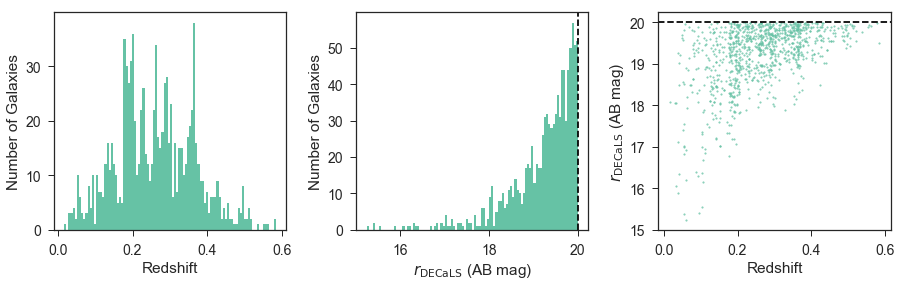

In [30]:
qa_zmag(result['ZTRUE'], result['RMAG'], maglabel=r'$r_{\rm DECaLS}$ (AB mag)', faintmag=20.0)

#### S/N vs apparent magnitude.

In [31]:
def qa_snr(res):
    rmag, snr_b, snr_r = res['RMAG'], res['SNR_B'], res['SNR_R']
    
    fig, ax = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
    ax[0].scatter(rmag, snr_b, s=40, alpha=0.95, edgecolor='k')
    ax[0].set_ylabel(r'S/N [$b$ channel]')
    ax[0].set_yscale('log')
    ax[0].grid()

    ax[1].scatter(rmag, snr_r, s=40, alpha=0.95, edgecolor='k')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(r'$r_{DECaLS}$ (AB mag)')
    ax[1].set_ylabel(r'S/N [$r$ channel]')
    ax[1].grid()
    
    plt.subplots_adjust(hspace=0.1)

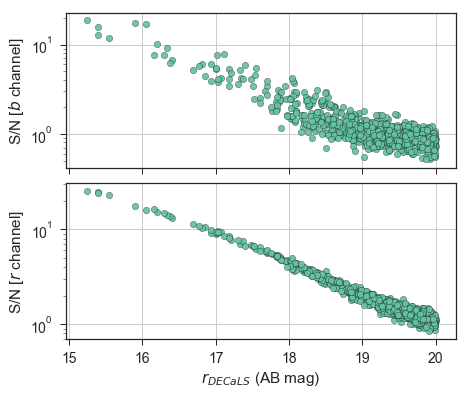

In [32]:
qa_snr(result)

In [33]:
def zstats(res):
    z = res['ZTRUE']
    dz = (res['Z'] - z)
    dzr = dz / (1 + z)
    s1 = (res['ZWARN'] == 0)
    s2 = (res['ZWARN'] == 0) & (np.abs(dzr) < 0.003)
    s3 = (res['ZWARN'] == 0) & (np.abs(dzr) >= 0.003)
    s4 = (res['ZWARN'] != 0)
    s5 = np.logical_and( np.logical_or( (res['ZWARN'] == 0), (res['ZWARN'] == 4) ), (np.abs(dzr) < 0.003) )

    return z, dz, dzr, s1, s2, s3, s4, s5

In [34]:
def gethist(quantity, res, range=None):
    """Generate the histogram (and Poisson uncertainty) for various 
    sample cuts.  See zstats() for details.

    """
    var = res[quantity]
    z, dz, dzr, s1, s2, s3, s4, s5 = zstats(res)    

    h0, bins = np.histogram(var, bins=100, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)
    h2, _ = np.histogram(var[s2], bins=bins)
    h3, _ = np.histogram(var[s3], bins=bins)
    h4, _ = np.histogram(var[s4], bins=bins)
    h5, _ = np.histogram(var[s5], bins=bins)

    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]
    h2 = h2[good]
    h3 = h3[good]
    h4 = h4[good]
    h5 = h5[good]
    
    vv = hv / h0
    
    def _eff(k, n):
        eff = k / (n + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    e2, ee2 = _eff(h2, h0)
    e3, ee3 = _eff(h3, h0)
    e4, ee4 = _eff(h4, h0)
    e5, ee5 = _eff(h5, h0)
    
    return vv, e1, e2, e3, e4, e5, ee1, ee2, ee3, ee4, ee5

#### Redshift efficiency vs various measured and intrinsic quantities.

In [35]:
def qa_efficiency(res, pngfile=None):
    """Redshift efficiency vs S/N, rmag, g-r color, redshift, 
    and D(4000).
    
    """
    from matplotlib.ticker import ScalarFormatter

    fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharey=True)
    xlabel = (r'$r_{DECaLS}$ (AB mag)', 'True Redshift $z$', r'S/N [$r$ channel]', 
              r'S/N [$b$ channel]', r'Apparent $g - r$', '$D_{n}(4000)$')
    for thisax, xx, dolog, label in zip(ax.flat, ('RMAG', 'ZTRUE', 'SNR_R', 'SNR_B', 'GR', 'D4000'), 
                                        (0, 0, 0, 0, 0, 0), xlabel):
                                         
        mm, e1, e2, e3, e4, e5, ee1, ee2, ee3, ee4, ee5 = gethist(xx, res)
        thisax.errorbar(mm, e1, ee1, fmt='o', label='ZWARN=0')
        thisax.errorbar(mm, e2, ee2, fmt='o', label='ZWARN=0, $dz/(1+z)<0.003$')
        thisax.errorbar(mm, e3, ee3, fmt='o', label='ZWARN=0, $dz/(1+z)\geq 0.003$')
        #thisax.errorbar(mm, e4, ee4, fmt='o', label='ZWARN>0')

        thisax.set_xlabel(label)
        if dolog:
            thisax.set_xscale('log')
            thisax.xaxis.set_major_formatter(ScalarFormatter())
        
        thisax.axhline(y=1, ls='--', color='k')
        thisax.grid()
        thisax.set_ylim([0, 1.1])
        
    ax[0][0].set_ylabel('Redshift Efficiency')
    ax[1][0].set_ylabel('Redshift Efficiency')
    ax[2][0].set_ylabel('Redshift Efficiency')
    
    ax[0][0].legend(loc='lower left', fontsize=12)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
    if pngfile:
        plt.savefig(pngfile)    

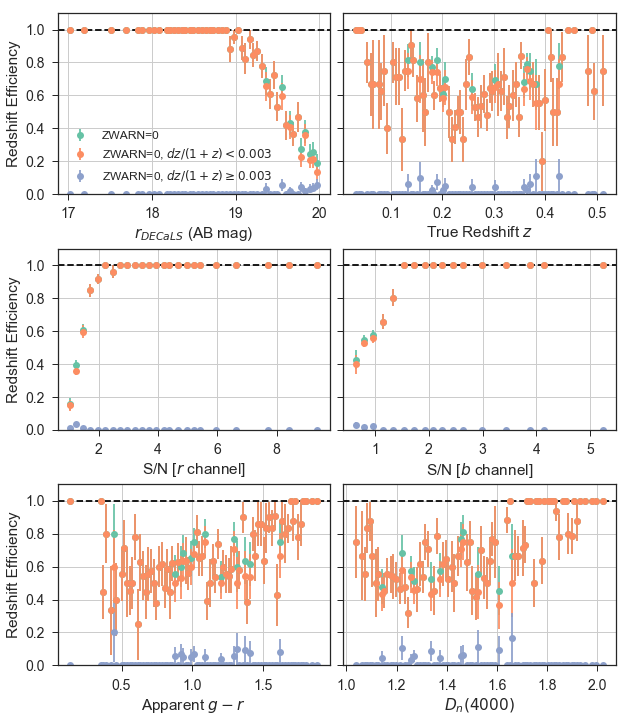

In [36]:
qa_efficiency(result)

#### The most common failure mode seems to be ZWARN==4 (i.e., small delta-chi2).
We should strive to recover as many of these redshifts as possible.

In [39]:
def qa_zwarn4(res):
    mm, e1, e2, e3, e4, e5, ee1, ee2, ee3, ee4, ee5 = gethist('RMAG', res)
    
    fig, ax = plt.subplots()
    ax.errorbar(mm, e1, ee1, fmt='o', label='ZWARN=0, $dz/(1+z)<0.003$')
    ax.errorbar(mm, e5, ee5, fmt='o', label='ZWARN=0 or ZWARN=4, $dz/(1+z)<0.003$')
    ax.axhline(y=1, ls='--', color='k')
    ax.grid()
    ax.set_xlabel(r'$r_{DECaLS}$ (AB mag)')
    ax.set_ylabel('Redshift Efficiency')
    ax.legend(loc='lower left')
    ax.set_ylim([0, 1.1])    

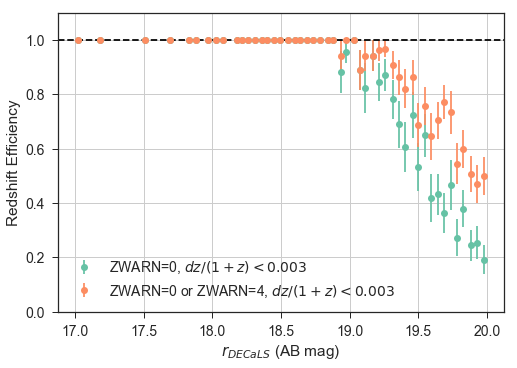

In [40]:
qa_zwarn4(result)